# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full
# from context import *
# from convert import *

In [16]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Experiment

In [21]:
"""Set experimental parameters."""
N = 5  # TODO: Get this from the stabilizer code.
expr_num = 20
channel_sample = 10_000

# Depolarizing noise rates.
pvalues = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

In [22]:
"""Run the experiment."""
fid_list = np.ones_like(pvalues)

for (i, p) in enumerate(pvalues):
    # Status update.
    print("Status: On noise rate", p, end="\r")

    # TODO: These loops are embarrassingly parallel.
    Tr_P_sigma_P_rho = []
    Tr_P_sigma_P = []
    for _ in range(expr_num):
        for _ in range(channel_sample):
            # Initial stabilizer state.
            state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
            gs0 = state.gs.copy()
            ps0 = state.ps.copy()

            # Apply single-qubit depolarizing noise.
            state = stoc_depolarize_map(state, p)

            # Do shadow tomography.
            obs = random_clifford_state(5)
            state.measure(obs)

            gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
                state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
            )
            _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N], ps0[:N], 0)
            Tr_P_sigma_P_rho.append(tmp_PsigmaP * tmp)
            Tr_P_sigma_P.append(tmp_PsigmaP)

    # Compute final fidelity.
    fid = ((2 ** N + 1) * np.mean(Tr_P_sigma_P_rho) - 1) / (
        np.mean(Tr_P_sigma_P) * (2 ** N + 1) - 2
    )
    fid_list[i] = fid

In [23]:
def FL(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

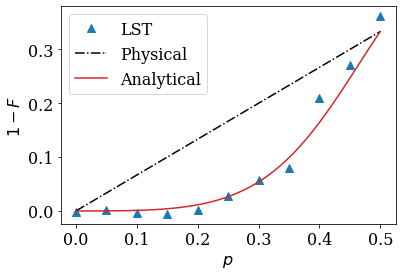

In [24]:
plt.plot(pvalues, 1 - fid_list, "^", markersize=8, label="LST")
plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")
plt.plot(
    np.linspace(0, 0.5, 50), 1 - FL(np.linspace(0, 0.5, 50)), c="C3", label="Analytical"
)

plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend();